In [1]:
!wget http://www.iapr-tc11.org/dataset/ICDAR_SignatureVerification/SigComp2011/sigComp2011-trainingSet.zip
!wget http://www.iapr-tc11.org/dataset/ICDAR_SignatureVerification/SigComp2011/sigComp2011-test.zip

--2020-12-06 08:31:15--  http://www.iapr-tc11.org/dataset/ICDAR_SignatureVerification/SigComp2011/sigComp2011-trainingSet.zip
Resolving www.iapr-tc11.org (www.iapr-tc11.org)... 157.16.221.56
Connecting to www.iapr-tc11.org (www.iapr-tc11.org)|157.16.221.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245154271 (234M) [application/zip]
Saving to: ‘sigComp2011-trainingSet.zip’

sigComp2011-trainin 100%[===================>] 233.80M  18.4MB/s    in 14s     

2020-12-06 08:31:29 (16.9 MB/s) - ‘sigComp2011-trainingSet.zip’ saved [245154271/245154271]

--2020-12-06 08:31:29--  http://www.iapr-tc11.org/dataset/ICDAR_SignatureVerification/SigComp2011/sigComp2011-test.zip
Resolving www.iapr-tc11.org (www.iapr-tc11.org)... 157.16.221.56
Connecting to www.iapr-tc11.org (www.iapr-tc11.org)|157.16.221.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 566029024 (540M) [application/zip]
Saving to: ‘sigComp2011-test.zip’

sigComp2011-test.zi 100%[=

In [2]:
!unzip -q -P "I hereby accept the SigComp 2011 disclaimer." sigComp2011-trainingSet.zip
!unzip -q -P "I hereby accept the SigComp 2011 disclaimer." sigComp2011-test.zip

In [1]:
import os
import sys

import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import stats
import random
from tqdm.notebook import tqdm

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image, ImageOps

Input Shape :  (64, 64, 3)


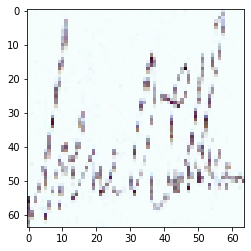

In [2]:
sample_file_path = "/content/trainingSet/OfflineSignatures/Dutch/TrainingSet/Offline Forgeries/0102014_01.png"

def read_and_preprocess_image(image_path):
    target_image_size = (64,64)
    target_color_scheme = cv2.COLOR_BGR2RGB
    return cv2.resize(cv2.cvtColor(cv2.imread(image_path), target_color_scheme),target_image_size)/255

"""def read_and_preprocess_image(image_path):
    target_image_size = (256,256)
    return np.asarray(tf.keras.preprocessing.image.load_img(image_path, grayscale=False, color_mode="rgb", target_size=target_image_size, interpolation="nearest"))
"""

sample_file = read_and_preprocess_image(sample_file_path)
print("Input Shape : ", sample_file.shape)
plt.imshow(sample_file)

In [3]:
training_genuine_dir = "/content/trainingSet/OfflineSignatures/Dutch/TrainingSet/Offline Genuine"
training_forgery_dir = "/content/trainingSet/OfflineSignatures/Dutch/TrainingSet/Offline Forgeries"

In [4]:
ids = []
for genuine in os.listdir(training_genuine_dir):
    id = int(genuine[:3])
    ids.append(id)
ids =set(ids)
print("Signers in training dataset :", ids)
print("No of signers in training dataset :", len(ids))

Signers in training dataset : {1, 2, 3, 4, 6, 9, 12, 14, 15, 16}
No of signers in training dataset : 10


In [5]:
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=12,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     zoom_range=0.05)

def siamese_training_dataset_list_generator(batch_size):
    genuine_dictionary = {}
    for genuine in os.listdir(training_genuine_dir):
        id = int(genuine[:3])
        image_data = read_and_preprocess_image(os.path.join(training_genuine_dir, genuine))
        if id in list(genuine_dictionary.keys()):
            genuine_dictionary[id].append(image_data)
        else:
            genuine_dictionary[id] = [image_data]
    
    forgery_dictionary = {}
    for forgery in os.listdir(training_forgery_dir):
        id = int(forgery[4:7])
        image_data = read_and_preprocess_image(os.path.join(training_forgery_dir, forgery))
        if id in list(forgery_dictionary.keys()):
            forgery_dictionary[id].append(image_data)
        else:
            forgery_dictionary[id] = [image_data]

    while(True):
        random_ids = random.choices(list(genuine_dictionary.keys()), k=batch_size)
        anchor = [random.choice(genuine_dictionary[id]) for id in random_ids]
        positive = [random.choice(genuine_dictionary[id]) for id in random_ids]
        negative = [random.choice(forgery_dictionary[id]) for id in random_ids]        
        yield (anchor, positive, negative)

In [6]:
def get_cnn_model():
    cnn_topology = [tf.keras.layers.Conv2D(64, (3,3), strides=(1, 1), activation='relu'),
                    #tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                    tf.keras.layers.Dropout(0.25),
                    
                    tf.keras.layers.Conv2D(64, (3,3), strides=(1, 1), activation='relu'),
                    #tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                    tf.keras.layers.Dropout(0.25),
                    tf.keras.layers.Conv2D(128, (3,3),strides=(1, 1), activation='relu'),
                    #tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                    tf.keras.layers.Dropout(0.25),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(256,activation='relu'),
                    tf.keras.layers.Dropout(0.25),
                    tf.keras.layers.Dense(256,activation='relu'),
                    tf.keras.layers.Dropout(0.25),
                    tf.keras.layers.Dense(64,activation='sigmoid')]
    model = tf.keras.Sequential(cnn_topology)
    return model

def get_triplet_loss_network(image_shape, optimizer, alpha, distance_type='euclidean'):

    basic_model = get_cnn_model()
    anchor  = tf.keras.Input(shape = image_shape)
    positive = tf.keras.Input(shape = image_shape)
    negative = tf.keras.Input(shape = image_shape)

    anchor_embedding = basic_model(anchor)
    positive_embedding = basic_model(positive)
    negative_embedding = basic_model(negative)

    model = tf.keras.Model(inputs=[anchor, positive, negative], outputs=[anchor_embedding, positive_embedding, negative_embedding])

    if(distance_type == 'euclidean'):
        pos = tf.math.sqrt(tf.math.squared_difference(anchor_embedding, positive_embedding))
        neg = tf.math.sqrt(tf.math.squared_difference(anchor_embedding, negative_embedding))
        loss = tf.math.maximum(tf.math.add(tf.math.subtract(pos, neg), alpha), 0)
        model.add_loss(loss)

    elif(distance_type == 'euclidean_squared'):
        pos = tf.math.squared_difference(anchor_embedding, positive_embedding)
        neg = tf.math.squared_difference(anchor_embedding, negative_embedding)
        loss = tf.math.maximum(tf.math.add(tf.math.subtract(pos, neg), alpha), 0)
        model.add_loss(loss)
    
    elif(distance_type == 'manhattan'):
        pos = tf.reduce_sum(tf.math.abs(tf.math.subtract(anchor_embedding, positive_embedding)))
        neg = tf.reduce_sum(tf.math.abs(tf.math.subtract(anchor_embedding, negative_embedding)))
        loss = tf.math.maximum(tf.math.add(tf.math.subtract(pos, neg), alpha), 0)
        model.add_loss(loss)
    
    elif(distance_type == 'cosine_similarity'):
        norm_anchor = tf.math.l2_normalize(anchor_embedding)
        norm_positive = tf.math.l2_normalize(positive_embedding)
        norm_negative = tf.math.l2_normalize(negative_embedding)

        pos = tf.reduce_sum(tf.multiply(norm_anchor, norm_positive))
        neg = tf.reduce_sum(tf.multiply(norm_anchor, norm_negative))

        loss = tf.math.maximum(tf.math.add(tf.math.subtract(neg, pos), alpha), 0)
        model.add_loss(loss)
    else:
        raise ValueError("Loss Type Incorrect")
    
    model.compile(optimizer = optimizer)

    return model

def get_binary_loss_network(image_shape, optimizer):
    basic_model = get_cnn_model()

    anchor  = tf.keras.Input(shape = image_shape)
    test = tf.keras.Input(shape = image_shape)

In [7]:
def image_augmenter(batch_size):
    image_list_generator = siamese_training_dataset_list_generator(batch_size)

    anchor_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    positive_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    negative_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

    samples = [[], [], []]
    for _ in range(1000//batch_size):
        anchor_images, positive_images, negative_images = next(image_list_generator)
        samples[0].extend(anchor_images)
        samples[1].extend(positive_images)
        samples[2].extend(negative_images)
    
    anchor_image_datagen.fit(np.array(samples[0]))
    positive_image_datagen.fit(np.array(samples[1]))
    negative_image_datagen.fit(np.array(samples[2]))

    while(True):
        anchor_images, positive_images, negative_images = next(image_list_generator)
        anchor_images, positive_images, negative_images = np.array(anchor_images), np.array(positive_images), np.array(negative_images)
        yield ([next(anchor_image_datagen.flow(anchor_images, shuffle=False, batch_size=batch_size)),
               next(positive_image_datagen.flow(positive_images, shuffle=False, batch_size=batch_size)),
               next(negative_image_datagen.flow(negative_images, shuffle=False, batch_size=batch_size))],
               [np.ones(shape=(batch_size,siamese.layers[3].output_shape[1])) for _ in range(3)])
        #yield ([anchor_images, positive_images, negative_images], [np.ones(shape=(batch_size,siamese.layers[3].output_shape[1])) for _ in range(3)])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           1374720     input_1[0][0]                    
                                                                 input_2[0][0]         

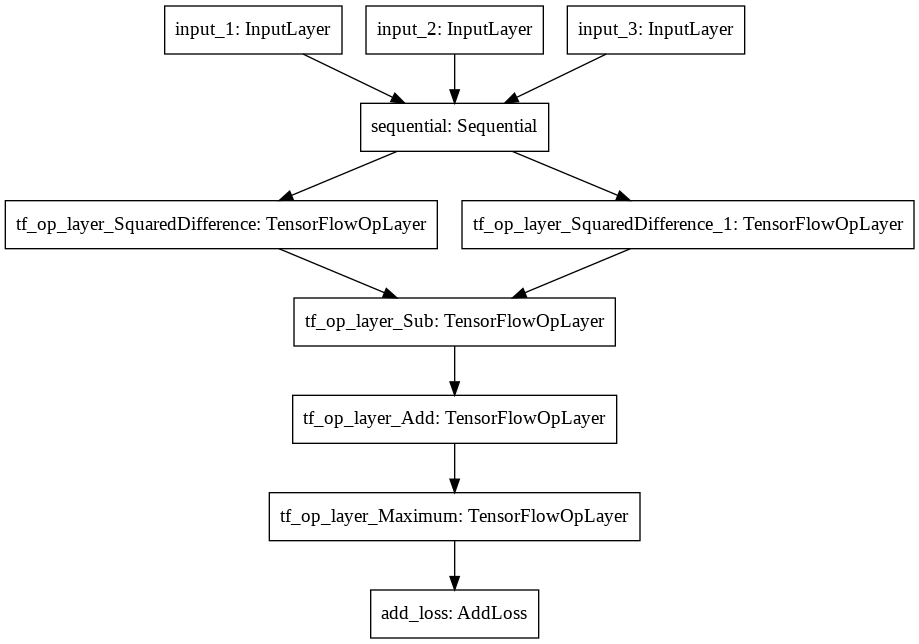

In [8]:
tf.keras.backend.clear_session()
siamese = get_triplet_loss_network(sample_file.shape, 'adagrad', 1, 'euclidean_squared')
print(siamese.summary())
tf.keras.utils.plot_model(siamese)

In [9]:
test_data_generator = image_augmenter(100)
train_data_generator = image_augmenter(10)
sample = next(test_data_generator)

Anchor


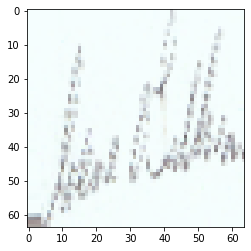

Positive


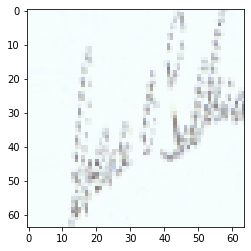

Negative


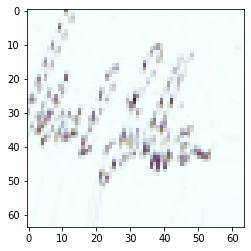

In [10]:
fig = plt.figure()
x = np.random.randint(0,99)
plt.imshow(Image.fromarray((sample[0][0][x]*(255/sample[0][0][x].max())).astype(np.uint8)))
print("Anchor")
plt.show()
plt.imshow(Image.fromarray((sample[0][1][x]*(255/sample[0][1][x].max())).astype(np.uint8)))
print("Positive")
plt.show()
plt.imshow(Image.fromarray((sample[0][2][x]*(255/sample[0][2][x].max())).astype(np.uint8)))
print("Negative")
plt.show()

In [ ]:
embedding_filepath = "embedding.h5"

In [ ]:
class EmbeddingSaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, embedding_filepath):
        super().__init__()
        self.min_validation_loss = np.inf
        self.embedding_filepath = embedding_filepath

    def on_epoch_end(self, epoch, logs=None):
        if(logs['val_loss']<self.min_validation_loss):
            self.min_validation_loss = logs['val_loss']
            self.model.layers[3].save(self.embedding_filepath)
            print("\nEnd epoch {} of training; New Minimum Validation Loss : {}, Saving Model to : {}".format(epoch, logs['val_loss'], self.embedding_filepath))

In [ ]:
fit_history = siamese.fit(train_data_generator, epochs=30,  validation_data = sample, steps_per_epoch=500, callbacks=[EmbeddingSaveCallback(embedding_filepath)])

Epoch 1/30
499/500 [============================>.] - ETA: 0s - loss: 0.9998
End epoch 0 of training; New Minimum Validation Loss : 0.9999887347221375, Saving Model to : embedding.h5
500/500 [==============================] - 20s 39ms/step - loss: 0.9998 - val_loss: 1.0000
Epoch 2/30
499/500 [============================>.] - ETA: 0s - loss: 1.0003
End epoch 1 of training; New Minimum Validation Loss : 0.999967634677887, Saving Model to : embedding.h5
500/500 [==============================] - 19s 38ms/step - loss: 1.0003 - val_loss: 1.0000
Epoch 3/30
500/500 [==============================] - ETA: 0s - loss: 0.9994
End epoch 2 of training; New Minimum Validation Loss : 0.9999253749847412, Saving Model to : embedding.h5
500/500 [==============================] - 19s 38ms/step - loss: 0.9994 - val_loss: 0.9999
Epoch 4/30
500/500 [==============================] - ETA: 0s - loss: 0.9991
End epoch 3 of training; New Minimum Validation Loss : 0.9998604655265808, Saving Model to : embedding

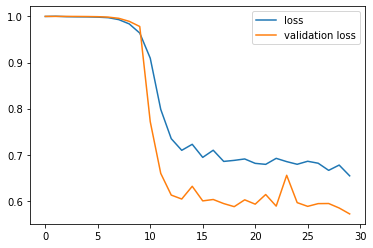

In [ ]:
loss_hist = pd.Series(fit_history.history['loss'])
loss_hist.name = 'loss'
val_loss_hist = pd.Series(fit_history.history['val_loss'])
val_loss_hist.name = 'validation loss'
pd.DataFrame([loss_hist, val_loss_hist]).T.plot()

In [11]:
embedding= tf.keras.models.load_model('embedding.h5', compile=False)
embedding.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       7

In [12]:
def comparator_dataset_generator(batch_size):
    image_list_generator = image_augmenter(batch_size//2)
    #image_list_generator = siamese_training_dataset_list_generator(batch_size//2)
    
    while(True):
        anchor_images, positive_images, negative_images = next(image_list_generator)[0]
        anchor_images, positive_images, negative_images = np.array(anchor_images), np.array(positive_images), np.array(negative_images)

        positive_embeddings = embedding.predict(anchor_images)-embedding.predict(positive_images)
        negative_embeddings = embedding.predict(anchor_images)-embedding.predict(negative_images)
        X = np.concatenate((positive_embeddings, negative_embeddings))
        y = np.concatenate((np.ones(len(anchor_images)), np.zeros(len(anchor_images))))
        yield X ,y 

In [13]:
comparator_dg = comparator_dataset_generator(256)

In [14]:
siam_gen = siamese_training_dataset_list_generator(128)

In [15]:
siam_sample = next(comparator_dg) 

In [16]:
np.array(siam_sample[1]).shape
#(embedding(np.array(siam_sample[0])[0][x:x+1]))

(256,)

In [17]:
x = np.random.randint(0,255)

print(siam_sample[0][x:x+1])
print(siam_sample[0][x+1:x+2])
#print(siam_sample[0][x:x+1]))




[[ 0.99960685  0.9997213   0.9997712   0.99943674 -0.9996737   0.9997977
  -0.9998681   0.99963677 -0.999782    0.9995318  -0.9997654   0.9997231
  -0.9997699  -0.99986005  0.9997815  -0.999533   -0.9996375   0.9995971
  -0.9997809  -0.99968255  0.9995269  -0.99986875  0.9998158   0.9998599
  -0.99975777  0.99980825  0.99955857  0.9997246   0.9996554   0.9994811
  -0.999904   -0.99978817 -0.9997855  -0.99960667 -0.99956423  0.99983263
  -0.9996468  -0.9996618  -0.99947244 -0.9997762  -0.99957186 -0.99972975
  -0.99978536 -0.9998326   0.9995657  -0.99967825  0.9999021   0.9996721
  -0.9992408  -0.9997259   0.99965507 -0.99955404 -0.99979025 -0.9996904
  -0.99970675 -0.99950206  0.999611    0.99956864 -0.99974996 -0.99974614
   0.999628   -0.9997292   0.9996433  -0.99951   ]]
[[ 0.9065904   0.9223431   0.8283091   0.8461576  -0.8811471   0.8920715
  -0.89588153  0.9114619  -0.8895247   0.8595569  -0.75734675  0.86685425
  -0.87064606 -0.96254414  0.84297884 -0.78702915 -0.8637173   0.847

In [18]:
comparator = tf.keras.Sequential()
comparator.add(tf.keras.Input(shape = (embedding.output_shape[1], )))
comparator.add(tf.keras.layers.Dense(1024, activation='tanh'))
comparator.add(tf.keras.layers.Dropout(0.25))
comparator.add(tf.keras.layers.Dense(512, activation='tanh'))
comparator.add(tf.keras.layers.Dropout(0.15))
#comparator.add(tf.keras.layers.Dense(128, activation='tanh'))
#comparator.add(tf.keras.layers.Dropout(0.15))
#comparator.add(tf.keras.layers.Dense(128, activation='tanh'))
#comparator.add(tf.keras.layers.Dropout(0.15))
comparator.add(tf.keras.layers.Dense(128, activation='tanh'))
comparator.add(tf.keras.layers.Dense(1, activation='sigmoid'))
comparator.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath="/content/Best_Weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
comparator.fit(comparator_dg, epochs=100,  validation_data = siam_sample, steps_per_epoch=100, callbacks=callbacks_list)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.7792
Epoch 00001: val_accuracy improved from -inf to 0.80859, saving model to /content/Best_Weights.hdf5
100/100 [==============================] - 50s 498ms/step - loss: 0.5231 - accuracy: 0.7792 - val_loss: 0.4762 - val_accuracy: 0.8086
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.4919 - accuracy: 0.7978
Epoch 00002: val_accuracy improved from 0.80859 to 0.81250, saving model to /content/Best_Weights.hdf5
100/100 [==============================] - 50s 499ms/step - loss: 0.4919 - accuracy: 0.7978 - val_loss: 0.4831 - val_accuracy: 0.8125
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.8056
Epoch 00003: val_accuracy did not improve from 0.81250
100/100 [==============================] - 50s 497ms/step - loss: 0.4776 - accuracy: 0.8056 - val_loss: 0.4614 - val_accuracy: 0.8086
Epoch 4/100
100/100 [============================

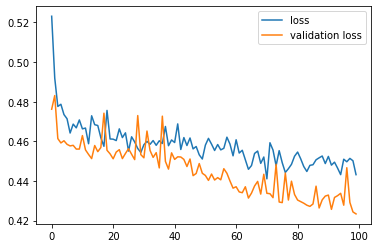

In [19]:
###Because we forgot to save the history object returned by the fit method lol

string = """Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.7792
Epoch 00001: val_accuracy improved from -inf to 0.80859, saving model to /content/Best_Weights.hdf5
100/100 [==============================] - 50s 498ms/step - loss: 0.5231 - accuracy: 0.7792 - val_loss: 0.4762 - val_accuracy: 0.8086
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.4919 - accuracy: 0.7978
Epoch 00002: val_accuracy improved from 0.80859 to 0.81250, saving model to /content/Best_Weights.hdf5
100/100 [==============================] - 50s 499ms/step - loss: 0.4919 - accuracy: 0.7978 - val_loss: 0.4831 - val_accuracy: 0.8125
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.8056
Epoch 00003: val_accuracy did not improve from 0.81250
100/100 [==============================] - 50s 497ms/step - loss: 0.4776 - accuracy: 0.8056 - val_loss: 0.4614 - val_accuracy: 0.8086
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 0.4787 - accuracy: 0.8042
Epoch 00004: val_accuracy did not improve from 0.81250
100/100 [==============================] - 50s 498ms/step - loss: 0.4787 - accuracy: 0.8042 - val_loss: 0.4592 - val_accuracy: 0.8086
Epoch 5/100
100/100 [==============================] - ETA: 0s - loss: 0.4735 - accuracy: 0.8064
Epoch 00005: val_accuracy improved from 0.81250 to 0.81641, saving model to /content/Best_Weights.hdf5
100/100 [==============================] - 50s 502ms/step - loss: 0.4735 - accuracy: 0.8064 - val_loss: 0.4603 - val_accuracy: 0.8164
Epoch 6/100
100/100 [==============================] - ETA: 0s - loss: 0.4714 - accuracy: 0.8054
Epoch 00006: val_accuracy improved from 0.81641 to 0.82422, saving model to /content/Best_Weights.hdf5
100/100 [==============================] - 50s 497ms/step - loss: 0.4714 - accuracy: 0.8054 - val_loss: 0.4585 - val_accuracy: 0.8242
Epoch 7/100
100/100 [==============================] - ETA: 0s - loss: 0.4642 - accuracy: 0.8100
Epoch 00007: val_accuracy did not improve from 0.82422
100/100 [==============================] - 50s 502ms/step - loss: 0.4642 - accuracy: 0.8100 - val_loss: 0.4577 - val_accuracy: 0.8086
Epoch 8/100
100/100 [==============================] - ETA: 0s - loss: 0.4687 - accuracy: 0.8061
Epoch 00008: val_accuracy did not improve from 0.82422
100/100 [==============================] - 50s 501ms/step - loss: 0.4687 - accuracy: 0.8061 - val_loss: 0.4580 - val_accuracy: 0.8242
Epoch 9/100
100/100 [==============================] - ETA: 0s - loss: 0.4668 - accuracy: 0.8065
Epoch 00009: val_accuracy did not improve from 0.82422
100/100 [==============================] - 50s 503ms/step - loss: 0.4668 - accuracy: 0.8065 - val_loss: 0.4561 - val_accuracy: 0.8125
Epoch 10/100
100/100 [==============================] - ETA: 0s - loss: 0.4708 - accuracy: 0.8036
Epoch 00010: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 508ms/step - loss: 0.4708 - accuracy: 0.8036 - val_loss: 0.4561 - val_accuracy: 0.8125
Epoch 11/100
100/100 [==============================] - ETA: 0s - loss: 0.4663 - accuracy: 0.8075
Epoch 00011: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 508ms/step - loss: 0.4663 - accuracy: 0.8075 - val_loss: 0.4629 - val_accuracy: 0.8086
Epoch 12/100
100/100 [==============================] - ETA: 0s - loss: 0.4667 - accuracy: 0.8085
Epoch 00012: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 508ms/step - loss: 0.4667 - accuracy: 0.8085 - val_loss: 0.4557 - val_accuracy: 0.8242
Epoch 13/100
100/100 [==============================] - ETA: 0s - loss: 0.4588 - accuracy: 0.8123
Epoch 00013: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 506ms/step - loss: 0.4588 - accuracy: 0.8123 - val_loss: 0.4534 - val_accuracy: 0.8164
Epoch 14/100
100/100 [==============================] - ETA: 0s - loss: 0.4729 - accuracy: 0.8037
Epoch 00014: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 508ms/step - loss: 0.4729 - accuracy: 0.8037 - val_loss: 0.4513 - val_accuracy: 0.8242
Epoch 15/100
100/100 [==============================] - ETA: 0s - loss: 0.4684 - accuracy: 0.8057
Epoch 00015: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 511ms/step - loss: 0.4684 - accuracy: 0.8057 - val_loss: 0.4579 - val_accuracy: 0.8125
Epoch 16/100
100/100 [==============================] - ETA: 0s - loss: 0.4680 - accuracy: 0.8059
Epoch 00016: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 515ms/step - loss: 0.4680 - accuracy: 0.8059 - val_loss: 0.4548 - val_accuracy: 0.8164
Epoch 17/100
100/100 [==============================] - ETA: 0s - loss: 0.4618 - accuracy: 0.8087
Epoch 00017: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 515ms/step - loss: 0.4618 - accuracy: 0.8087 - val_loss: 0.4569 - val_accuracy: 0.8086
Epoch 18/100
100/100 [==============================] - ETA: 0s - loss: 0.4575 - accuracy: 0.8120
Epoch 00018: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 517ms/step - loss: 0.4575 - accuracy: 0.8120 - val_loss: 0.4742 - val_accuracy: 0.8008
Epoch 19/100
100/100 [==============================] - ETA: 0s - loss: 0.4756 - accuracy: 0.7989
Epoch 00019: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 513ms/step - loss: 0.4756 - accuracy: 0.7989 - val_loss: 0.4555 - val_accuracy: 0.8203
Epoch 20/100
100/100 [==============================] - ETA: 0s - loss: 0.4612 - accuracy: 0.8093
Epoch 00020: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 513ms/step - loss: 0.4612 - accuracy: 0.8093 - val_loss: 0.4537 - val_accuracy: 0.8164
Epoch 21/100
100/100 [==============================] - ETA: 0s - loss: 0.4611 - accuracy: 0.8106
Epoch 00021: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 514ms/step - loss: 0.4611 - accuracy: 0.8106 - val_loss: 0.4512 - val_accuracy: 0.8164
Epoch 22/100
100/100 [==============================] - ETA: 0s - loss: 0.4604 - accuracy: 0.8113
Epoch 00022: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 513ms/step - loss: 0.4604 - accuracy: 0.8113 - val_loss: 0.4546 - val_accuracy: 0.8203
Epoch 23/100
100/100 [==============================] - ETA: 0s - loss: 0.4663 - accuracy: 0.8061
Epoch 00023: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 512ms/step - loss: 0.4663 - accuracy: 0.8061 - val_loss: 0.4558 - val_accuracy: 0.8164
Epoch 24/100
100/100 [==============================] - ETA: 0s - loss: 0.4619 - accuracy: 0.8092
Epoch 00024: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 507ms/step - loss: 0.4619 - accuracy: 0.8092 - val_loss: 0.4513 - val_accuracy: 0.8164
Epoch 25/100
100/100 [==============================] - ETA: 0s - loss: 0.4643 - accuracy: 0.8061
Epoch 00025: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 507ms/step - loss: 0.4643 - accuracy: 0.8061 - val_loss: 0.4539 - val_accuracy: 0.8125
Epoch 26/100
100/100 [==============================] - ETA: 0s - loss: 0.4551 - accuracy: 0.8116
Epoch 00026: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 508ms/step - loss: 0.4551 - accuracy: 0.8116 - val_loss: 0.4563 - val_accuracy: 0.8242
Epoch 27/100
100/100 [==============================] - ETA: 0s - loss: 0.4623 - accuracy: 0.8093
Epoch 00027: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 509ms/step - loss: 0.4623 - accuracy: 0.8093 - val_loss: 0.4535 - val_accuracy: 0.8203
Epoch 28/100
100/100 [==============================] - ETA: 0s - loss: 0.4597 - accuracy: 0.8100
Epoch 00028: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 513ms/step - loss: 0.4597 - accuracy: 0.8100 - val_loss: 0.4508 - val_accuracy: 0.8164
Epoch 29/100
100/100 [==============================] - ETA: 0s - loss: 0.4564 - accuracy: 0.8107
Epoch 00029: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 517ms/step - loss: 0.4564 - accuracy: 0.8107 - val_loss: 0.4730 - val_accuracy: 0.8008
Epoch 30/100
100/100 [==============================] - ETA: 0s - loss: 0.4544 - accuracy: 0.8150
Epoch 00030: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 514ms/step - loss: 0.4544 - accuracy: 0.8150 - val_loss: 0.4533 - val_accuracy: 0.8086
Epoch 31/100
100/100 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.8118
Epoch 00031: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 513ms/step - loss: 0.4583 - accuracy: 0.8118 - val_loss: 0.4517 - val_accuracy: 0.8203
Epoch 32/100
100/100 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.8102
Epoch 00032: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 516ms/step - loss: 0.4600 - accuracy: 0.8102 - val_loss: 0.4652 - val_accuracy: 0.8047
Epoch 33/100
100/100 [==============================] - ETA: 0s - loss: 0.4585 - accuracy: 0.8121
Epoch 00033: val_accuracy did not improve from 0.82422
100/100 [==============================] - 51s 513ms/step - loss: 0.4585 - accuracy: 0.8121 - val_loss: 0.4554 - val_accuracy: 0.8125
Epoch 34/100
100/100 [==============================] - ETA: 0s - loss: 0.4604 - accuracy: 0.8107
Epoch 00034: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 519ms/step - loss: 0.4604 - accuracy: 0.8107 - val_loss: 0.4519 - val_accuracy: 0.8242
Epoch 35/100
100/100 [==============================] - ETA: 0s - loss: 0.4580 - accuracy: 0.8118
Epoch 00035: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 519ms/step - loss: 0.4580 - accuracy: 0.8118 - val_loss: 0.4543 - val_accuracy: 0.8203
Epoch 36/100
100/100 [==============================] - ETA: 0s - loss: 0.4603 - accuracy: 0.8112
Epoch 00036: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 517ms/step - loss: 0.4603 - accuracy: 0.8112 - val_loss: 0.4466 - val_accuracy: 0.8203
Epoch 37/100
100/100 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.8117
Epoch 00037: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 520ms/step - loss: 0.4589 - accuracy: 0.8117 - val_loss: 0.4727 - val_accuracy: 0.8008
Epoch 38/100
100/100 [==============================] - ETA: 0s - loss: 0.4675 - accuracy: 0.8045
Epoch 00038: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 522ms/step - loss: 0.4675 - accuracy: 0.8045 - val_loss: 0.4499 - val_accuracy: 0.8242
Epoch 39/100
100/100 [==============================] - ETA: 0s - loss: 0.4578 - accuracy: 0.8125
Epoch 00039: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 518ms/step - loss: 0.4578 - accuracy: 0.8125 - val_loss: 0.4460 - val_accuracy: 0.8203
Epoch 40/100
100/100 [==============================] - ETA: 0s - loss: 0.4607 - accuracy: 0.8098
Epoch 00040: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 517ms/step - loss: 0.4607 - accuracy: 0.8098 - val_loss: 0.4542 - val_accuracy: 0.8203
Epoch 41/100
100/100 [==============================] - ETA: 0s - loss: 0.4594 - accuracy: 0.8129
Epoch 00041: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 520ms/step - loss: 0.4594 - accuracy: 0.8129 - val_loss: 0.4509 - val_accuracy: 0.8242
Epoch 42/100
100/100 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.8060
Epoch 00042: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 517ms/step - loss: 0.4688 - accuracy: 0.8060 - val_loss: 0.4522 - val_accuracy: 0.8203
Epoch 43/100
100/100 [==============================] - ETA: 0s - loss: 0.4559 - accuracy: 0.8154
Epoch 00043: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 518ms/step - loss: 0.4559 - accuracy: 0.8154 - val_loss: 0.4521 - val_accuracy: 0.8242
Epoch 44/100
100/100 [==============================] - ETA: 0s - loss: 0.4619 - accuracy: 0.8078
Epoch 00044: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 517ms/step - loss: 0.4619 - accuracy: 0.8078 - val_loss: 0.4509 - val_accuracy: 0.8125
Epoch 45/100
100/100 [==============================] - ETA: 0s - loss: 0.4579 - accuracy: 0.8131
Epoch 00045: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 516ms/step - loss: 0.4579 - accuracy: 0.8131 - val_loss: 0.4473 - val_accuracy: 0.8242
Epoch 46/100
100/100 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.8085
Epoch 00046: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 516ms/step - loss: 0.4617 - accuracy: 0.8085 - val_loss: 0.4511 - val_accuracy: 0.8125
Epoch 47/100
100/100 [==============================] - ETA: 0s - loss: 0.4562 - accuracy: 0.8134
Epoch 00047: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 522ms/step - loss: 0.4562 - accuracy: 0.8134 - val_loss: 0.4427 - val_accuracy: 0.8203
Epoch 48/100
100/100 [==============================] - ETA: 0s - loss: 0.4574 - accuracy: 0.8134
Epoch 00048: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 518ms/step - loss: 0.4574 - accuracy: 0.8134 - val_loss: 0.4438 - val_accuracy: 0.8203
Epoch 49/100
100/100 [==============================] - ETA: 0s - loss: 0.4532 - accuracy: 0.8127
Epoch 00049: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 523ms/step - loss: 0.4532 - accuracy: 0.8127 - val_loss: 0.4488 - val_accuracy: 0.8242
Epoch 50/100
100/100 [==============================] - ETA: 0s - loss: 0.4511 - accuracy: 0.8148
Epoch 00050: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 521ms/step - loss: 0.4511 - accuracy: 0.8148 - val_loss: 0.4439 - val_accuracy: 0.8242
Epoch 51/100
100/100 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 0.8111
Epoch 00051: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 523ms/step - loss: 0.4581 - accuracy: 0.8111 - val_loss: 0.4428 - val_accuracy: 0.8125
Epoch 52/100
100/100 [==============================] - ETA: 0s - loss: 0.4615 - accuracy: 0.8129
Epoch 00052: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 521ms/step - loss: 0.4615 - accuracy: 0.8129 - val_loss: 0.4403 - val_accuracy: 0.8242
Epoch 53/100
100/100 [==============================] - ETA: 0s - loss: 0.4586 - accuracy: 0.8123
Epoch 00053: val_accuracy did not improve from 0.82422
100/100 [==============================] - 53s 528ms/step - loss: 0.4586 - accuracy: 0.8123 - val_loss: 0.4435 - val_accuracy: 0.8203
Epoch 54/100
100/100 [==============================] - ETA: 0s - loss: 0.4554 - accuracy: 0.8141
Epoch 00054: val_accuracy did not improve from 0.82422
100/100 [==============================] - 53s 525ms/step - loss: 0.4554 - accuracy: 0.8141 - val_loss: 0.4405 - val_accuracy: 0.8242
Epoch 55/100
100/100 [==============================] - ETA: 0s - loss: 0.4584 - accuracy: 0.8111
Epoch 00055: val_accuracy did not improve from 0.82422
100/100 [==============================] - 52s 524ms/step - loss: 0.4584 - accuracy: 0.8111 - val_loss: 0.4417 - val_accuracy: 0.8242
Epoch 56/100
100/100 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.8129
Epoch 00056: val_accuracy did not improve from 0.82422
100/100 [==============================] - 53s 530ms/step - loss: 0.4557 - accuracy: 0.8129 - val_loss: 0.4406 - val_accuracy: 0.8242
Epoch 57/100
100/100 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.8147
Epoch 00057: val_accuracy did not improve from 0.82422
100/100 [==============================] - 53s 533ms/step - loss: 0.4565 - accuracy: 0.8147 - val_loss: 0.4462 - val_accuracy: 0.8164
Epoch 58/100
100/100 [==============================] - ETA: 0s - loss: 0.4621 - accuracy: 0.8114
Epoch 00058: val_accuracy did not improve from 0.82422
100/100 [==============================] - 53s 534ms/step - loss: 0.4621 - accuracy: 0.8114 - val_loss: 0.4439 - val_accuracy: 0.8242
Epoch 59/100
100/100 [==============================] - ETA: 0s - loss: 0.4586 - accuracy: 0.8122
Epoch 00059: val_accuracy did not improve from 0.82422
100/100 [==============================] - 53s 532ms/step - loss: 0.4586 - accuracy: 0.8122 - val_loss: 0.4400 - val_accuracy: 0.8203
Epoch 60/100
100/100 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.8168
Epoch 00060: val_accuracy did not improve from 0.82422
100/100 [==============================] - 53s 531ms/step - loss: 0.4527 - accuracy: 0.8168 - val_loss: 0.4364 - val_accuracy: 0.8242
Epoch 61/100
100/100 [==============================] - ETA: 0s - loss: 0.4608 - accuracy: 0.8100
Epoch 00061: val_accuracy did not improve from 0.82422
100/100 [==============================] - 53s 530ms/step - loss: 0.4608 - accuracy: 0.8100 - val_loss: 0.4371 - val_accuracy: 0.8203
Epoch 62/100
100/100 [==============================] - ETA: 0s - loss: 0.4541 - accuracy: 0.8151
Epoch 00062: val_accuracy did not improve from 0.82422
100/100 [==============================] - 53s 531ms/step - loss: 0.4541 - accuracy: 0.8151 - val_loss: 0.4345 - val_accuracy: 0.8203
Epoch 63/100
100/100 [==============================] - ETA: 0s - loss: 0.4555 - accuracy: 0.8128
Epoch 00063: val_accuracy did not improve from 0.82422
100/100 [==============================] - 53s 529ms/step - loss: 0.4555 - accuracy: 0.8128 - val_loss: 0.4341 - val_accuracy: 0.8203
Epoch 64/100
100/100 [==============================] - ETA: 0s - loss: 0.4507 - accuracy: 0.8190
Epoch 00064: val_accuracy did not improve from 0.82422
100/100 [==============================] - 53s 529ms/step - loss: 0.4507 - accuracy: 0.8190 - val_loss: 0.4371 - val_accuracy: 0.8203
Epoch 65/100
100/100 [==============================] - ETA: 0s - loss: 0.4459 - accuracy: 0.8193
Epoch 00065: val_accuracy did not improve from 0.82422
100/100 [==============================] - 54s 536ms/step - loss: 0.4459 - accuracy: 0.8193 - val_loss: 0.4314 - val_accuracy: 0.8242
Epoch 66/100
100/100 [==============================] - ETA: 0s - loss: 0.4478 - accuracy: 0.8198
Epoch 00066: val_accuracy did not improve from 0.82422
100/100 [==============================] - 53s 532ms/step - loss: 0.4478 - accuracy: 0.8198 - val_loss: 0.4339 - val_accuracy: 0.8164
Epoch 67/100
100/100 [==============================] - ETA: 0s - loss: 0.4539 - accuracy: 0.8147
Epoch 00067: val_accuracy did not improve from 0.82422
100/100 [==============================] - 53s 534ms/step - loss: 0.4539 - accuracy: 0.8147 - val_loss: 0.4375 - val_accuracy: 0.8242
Epoch 68/100
100/100 [==============================] - ETA: 0s - loss: 0.4551 - accuracy: 0.8152
Epoch 00068: val_accuracy did not improve from 0.82422
100/100 [==============================] - 53s 533ms/step - loss: 0.4551 - accuracy: 0.8152 - val_loss: 0.4398 - val_accuracy: 0.8164
Epoch 69/100
100/100 [==============================] - ETA: 0s - loss: 0.4489 - accuracy: 0.8182
Epoch 00069: val_accuracy improved from 0.82422 to 0.82812, saving model to /content/Best_Weights.hdf5
100/100 [==============================] - 53s 533ms/step - loss: 0.4489 - accuracy: 0.8182 - val_loss: 0.4334 - val_accuracy: 0.8281
Epoch 70/100
100/100 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.8161
Epoch 00070: val_accuracy did not improve from 0.82812
100/100 [==============================] - 53s 532ms/step - loss: 0.4521 - accuracy: 0.8161 - val_loss: 0.4434 - val_accuracy: 0.8281
Epoch 71/100
100/100 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.8230
Epoch 00071: val_accuracy did not improve from 0.82812
100/100 [==============================] - 54s 535ms/step - loss: 0.4411 - accuracy: 0.8230 - val_loss: 0.4338 - val_accuracy: 0.8203
Epoch 72/100
100/100 [==============================] - ETA: 0s - loss: 0.4593 - accuracy: 0.8088
Epoch 00072: val_accuracy did not improve from 0.82812
100/100 [==============================] - 53s 532ms/step - loss: 0.4593 - accuracy: 0.8088 - val_loss: 0.4336 - val_accuracy: 0.8242
Epoch 73/100
100/100 [==============================] - ETA: 0s - loss: 0.4556 - accuracy: 0.8131
Epoch 00073: val_accuracy did not improve from 0.82812
100/100 [==============================] - 53s 534ms/step - loss: 0.4556 - accuracy: 0.8131 - val_loss: 0.4316 - val_accuracy: 0.8203
Epoch 74/100
100/100 [==============================] - ETA: 0s - loss: 0.4477 - accuracy: 0.8162
Epoch 00074: val_accuracy did not improve from 0.82812
100/100 [==============================] - 53s 534ms/step - loss: 0.4477 - accuracy: 0.8162 - val_loss: 0.4484 - val_accuracy: 0.8203
Epoch 75/100
100/100 [==============================] - ETA: 0s - loss: 0.4553 - accuracy: 0.8141
Epoch 00075: val_accuracy did not improve from 0.82812
100/100 [==============================] - 54s 536ms/step - loss: 0.4553 - accuracy: 0.8141 - val_loss: 0.4294 - val_accuracy: 0.8242
Epoch 76/100
100/100 [==============================] - ETA: 0s - loss: 0.4492 - accuracy: 0.8187
Epoch 00076: val_accuracy did not improve from 0.82812
100/100 [==============================] - 54s 541ms/step - loss: 0.4492 - accuracy: 0.8187 - val_loss: 0.4291 - val_accuracy: 0.8242
Epoch 77/100
100/100 [==============================] - ETA: 0s - loss: 0.4443 - accuracy: 0.8190
Epoch 00077: val_accuracy did not improve from 0.82812
100/100 [==============================] - 54s 536ms/step - loss: 0.4443 - accuracy: 0.8190 - val_loss: 0.4440 - val_accuracy: 0.8203
Epoch 78/100
100/100 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.8192
Epoch 00078: val_accuracy did not improve from 0.82812
100/100 [==============================] - 54s 538ms/step - loss: 0.4462 - accuracy: 0.8192 - val_loss: 0.4304 - val_accuracy: 0.8203
Epoch 79/100
100/100 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.8171
Epoch 00079: val_accuracy did not improve from 0.82812
100/100 [==============================] - 54s 538ms/step - loss: 0.4484 - accuracy: 0.8171 - val_loss: 0.4399 - val_accuracy: 0.8242
Epoch 80/100
100/100 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.8151
Epoch 00080: val_accuracy did not improve from 0.82812
100/100 [==============================] - 54s 539ms/step - loss: 0.4525 - accuracy: 0.8151 - val_loss: 0.4332 - val_accuracy: 0.8203
Epoch 81/100
100/100 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.8128
Epoch 00081: val_accuracy did not improve from 0.82812
100/100 [==============================] - 53s 534ms/step - loss: 0.4546 - accuracy: 0.8128 - val_loss: 0.4304 - val_accuracy: 0.8281
Epoch 82/100
100/100 [==============================] - ETA: 0s - loss: 0.4512 - accuracy: 0.8168
Epoch 00082: val_accuracy did not improve from 0.82812
100/100 [==============================] - 54s 541ms/step - loss: 0.4512 - accuracy: 0.8168 - val_loss: 0.4296 - val_accuracy: 0.8281
Epoch 83/100
100/100 [==============================] - ETA: 0s - loss: 0.4473 - accuracy: 0.8185
Epoch 00083: val_accuracy did not improve from 0.82812
100/100 [==============================] - 54s 537ms/step - loss: 0.4473 - accuracy: 0.8185 - val_loss: 0.4288 - val_accuracy: 0.8242
Epoch 84/100
100/100 [==============================] - ETA: 0s - loss: 0.4448 - accuracy: 0.8194
Epoch 00084: val_accuracy did not improve from 0.82812
100/100 [==============================] - 54s 537ms/step - loss: 0.4448 - accuracy: 0.8194 - val_loss: 0.4278 - val_accuracy: 0.8281
Epoch 85/100
100/100 [==============================] - ETA: 0s - loss: 0.4479 - accuracy: 0.8170
Epoch 00085: val_accuracy did not improve from 0.82812
100/100 [==============================] - 54s 539ms/step - loss: 0.4479 - accuracy: 0.8170 - val_loss: 0.4272 - val_accuracy: 0.8242
Epoch 86/100
100/100 [==============================] - ETA: 0s - loss: 0.4482 - accuracy: 0.8173
Epoch 00086: val_accuracy did not improve from 0.82812
100/100 [==============================] - 54s 537ms/step - loss: 0.4482 - accuracy: 0.8173 - val_loss: 0.4284 - val_accuracy: 0.8281
Epoch 87/100
100/100 [==============================] - ETA: 0s - loss: 0.4507 - accuracy: 0.8151
Epoch 00087: val_accuracy did not improve from 0.82812
100/100 [==============================] - 54s 537ms/step - loss: 0.4507 - accuracy: 0.8151 - val_loss: 0.4374 - val_accuracy: 0.8203
Epoch 88/100
100/100 [==============================] - ETA: 0s - loss: 0.4517 - accuracy: 0.8161
Epoch 00088: val_accuracy did not improve from 0.82812
100/100 [==============================] - 54s 541ms/step - loss: 0.4517 - accuracy: 0.8161 - val_loss: 0.4264 - val_accuracy: 0.8281
Epoch 89/100
100/100 [==============================] - ETA: 0s - loss: 0.4526 - accuracy: 0.8153
Epoch 00089: val_accuracy did not improve from 0.82812
100/100 [==============================] - 54s 541ms/step - loss: 0.4526 - accuracy: 0.8153 - val_loss: 0.4305 - val_accuracy: 0.8242
Epoch 90/100
100/100 [==============================] - ETA: 0s - loss: 0.4488 - accuracy: 0.8153
Epoch 00090: val_accuracy improved from 0.82812 to 0.83203, saving model to /content/Best_Weights.hdf5
100/100 [==============================] - 54s 539ms/step - loss: 0.4488 - accuracy: 0.8153 - val_loss: 0.4324 - val_accuracy: 0.8320
Epoch 91/100
100/100 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.8158
Epoch 00091: val_accuracy did not improve from 0.83203
100/100 [==============================] - 54s 543ms/step - loss: 0.4524 - accuracy: 0.8158 - val_loss: 0.4329 - val_accuracy: 0.8242
Epoch 92/100
100/100 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.8175
Epoch 00092: val_accuracy did not improve from 0.83203
100/100 [==============================] - 54s 540ms/step - loss: 0.4480 - accuracy: 0.8175 - val_loss: 0.4257 - val_accuracy: 0.8242
Epoch 93/100
100/100 [==============================] - ETA: 0s - loss: 0.4495 - accuracy: 0.8176
Epoch 00093: val_accuracy did not improve from 0.83203
100/100 [==============================] - 54s 542ms/step - loss: 0.4495 - accuracy: 0.8176 - val_loss: 0.4317 - val_accuracy: 0.8203
Epoch 94/100
100/100 [==============================] - ETA: 0s - loss: 0.4465 - accuracy: 0.8167
Epoch 00094: val_accuracy did not improve from 0.83203
100/100 [==============================] - 54s 538ms/step - loss: 0.4465 - accuracy: 0.8167 - val_loss: 0.4326 - val_accuracy: 0.8281
Epoch 95/100
100/100 [==============================] - ETA: 0s - loss: 0.4432 - accuracy: 0.8208
Epoch 00095: val_accuracy did not improve from 0.83203
100/100 [==============================] - 54s 539ms/step - loss: 0.4432 - accuracy: 0.8208 - val_loss: 0.4338 - val_accuracy: 0.8203
Epoch 96/100
100/100 [==============================] - ETA: 0s - loss: 0.4510 - accuracy: 0.8166
Epoch 00096: val_accuracy did not improve from 0.83203
100/100 [==============================] - 54s 538ms/step - loss: 0.4510 - accuracy: 0.8166 - val_loss: 0.4278 - val_accuracy: 0.8242
Epoch 97/100
100/100 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.8153
Epoch 00097: val_accuracy did not improve from 0.83203
100/100 [==============================] - 54s 540ms/step - loss: 0.4497 - accuracy: 0.8153 - val_loss: 0.4467 - val_accuracy: 0.8125
Epoch 98/100
100/100 [==============================] - ETA: 0s - loss: 0.4514 - accuracy: 0.8152
Epoch 00098: val_accuracy did not improve from 0.83203
100/100 [==============================] - 54s 538ms/step - loss: 0.4514 - accuracy: 0.8152 - val_loss: 0.4292 - val_accuracy: 0.8242
Epoch 99/100
100/100 [==============================] - ETA: 0s - loss: 0.4502 - accuracy: 0.8143
Epoch 00099: val_accuracy did not improve from 0.83203
100/100 [==============================] - 54s 538ms/step - loss: 0.4502 - accuracy: 0.8143 - val_loss: 0.4244 - val_accuracy: 0.8242
Epoch 100/100
100/100 [==============================] - ETA: 0s - loss: 0.4432 - accuracy: 0.8212
Epoch 00100: val_accuracy did not improve from 0.83203
100/100 [==============================] - 54s 539ms/step - loss: 0.4432 - accuracy: 0.8212 - val_loss: 0.4234 - val_accuracy: 0.8281"""

def get_training_statistics(string):
    lines = string.split("\n")
    prog_lines = list(filter(lambda x : x.find("val_accuracy:")>=0, lines))
    cleaner = lambda x : [float(x[x.find("loss:")+5:x.find("accuracy")-3].strip()), float(x[x.find("accuracy:")+9:x.find("val_loss")-3].strip()), float(x[x.find("val_loss:")+9:x.find("val_accuracy")-3].strip()), float(x[x.find("val_accuracy:")+13:].strip())]
    data = list(map(cleaner, prog_lines))
    df = pd.DataFrame(data, columns = ['loss', 'accuracy', 'validation loss', 'validation accuracy'])
    return df

comparator_training_history = get_training_statistics(string)

comparator_training_history[['loss', 'validation loss']].plot()

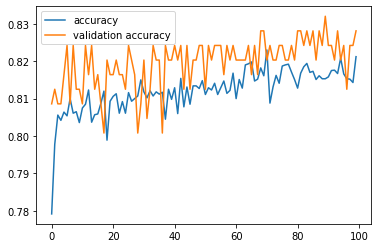

In [20]:
comparator_training_history[['accuracy', 'validation accuracy']].plot()

In [19]:
comparator.load_weights('comparator.hdf5')

In [20]:
comparator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              66560     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 657,153
Trainable params: 657,153
Non-trainable params: 0
________________________________________________

#Model testing begins here


In [21]:
testing_reference = "/content/Testdata_SigComp2011/SigComp11-Offlinetestset/Dutch/Reference(646)"
testing_questioned = "/content/Testdata_SigComp2011/SigComp11-Offlinetestset/Dutch/Questioned(1287)"

def get_reference_images_for_id(id):
    id_image_path = os.path.join(testing_reference, id)
    if os.path.exists(id_image_path):
        images = []
        for image_path in os.listdir(id_image_path):
            images.append(read_and_preprocess_image(os.path.join(id_image_path, image_path)))
        return images
    else:
        raise Exception("ID not in database")

def create_reference_data(id):
    images = get_reference_images_for_id(id)
    image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    image_datagen.fit(np.array(images))
    image_embeddings = embedding.predict(image_datagen.flow(np.array(random.choices(images, k = 100))))
    return image_embeddings, image_datagen

###Building database of known signers
reference_data = {}
for id in os.listdir(testing_reference):
    reference_data[id] = {}
    d = create_reference_data(id)
    reference_data[id]['refernce_embeddings'] = d[0]
    reference_data[id]['refernce_datagen'] = d[1]

def get_reference_data(id):
    return reference_data[id]['refernce_embeddings'], reference_data[id]['refernce_datagen']

def get_composite_prediction(id, image_file):
    reference_embeddings, datagen = get_reference_data(id)
    current_embedding = embedding.predict(datagen.flow(np.array([image_file])))
    prediction = comparator.predict(reference_embeddings-current_embedding)
    #return prediction
    return stats.mode(prediction>0.5).mode[0][0]

In [22]:
original_test_data = []
for id in os.listdir(testing_questioned):
    quentioned_id_path = os.path.join(testing_questioned, id)
    for image in os.listdir(quentioned_id_path):
        if(len(image.split(".")[0])<7):
            original_test_data.append([id, read_and_preprocess_image(os.path.join(quentioned_id_path,image)), True])
        else:
            original_test_data.append([id, read_and_preprocess_image(os.path.join(quentioned_id_path,image)), False])

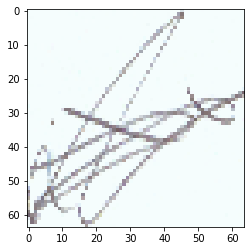

In [28]:
plt.imshow(original_test_data[1][1])
plt.show()

In [34]:
test_data = original_test_data[1:2]
test_data

[['036', array([[[0.96078431, 0.99215686, 0.99215686],
          [0.96078431, 0.99215686, 0.99215686],
          [0.96078431, 0.99215686, 0.99215686],
          ...,
          [0.96078431, 0.99215686, 0.99215686],
          [0.96078431, 0.99215686, 0.99215686],
          [0.96078431, 0.99215686, 0.99215686]],
  
         [[0.96078431, 0.99215686, 0.99215686],
          [0.96078431, 0.99215686, 0.99215686],
          [0.96078431, 0.99215686, 0.99215686],
          ...,
          [0.96078431, 0.99215686, 0.99215686],
          [0.96078431, 0.99215686, 0.99215686],
          [0.96078431, 0.99215686, 0.99215686]],
  
         [[0.95686275, 0.98823529, 0.98823529],
          [0.95686275, 0.98823529, 0.98823529],
          [0.96078431, 0.99215686, 0.99215686],
          ...,
          [0.96078431, 0.99215686, 0.98823529],
          [0.96078431, 0.99215686, 0.99215686],
          [0.96078431, 0.99215686, 0.99215686]],
  
         ...,
  
         [[0.87843137, 0.90588235, 0.9372549 ],
       

In [36]:
test_data_x = [(test_dat[0], test_dat[1]) for test_dat in test_data]
test_data_y = [test_dat[2] for test_dat in test_data]
test_data_y_hat = list(map(lambda x : get_composite_prediction(*x), test_data_x))
print(test_data_y_hat)
print(test_data_y)

[True]
[True]


In [33]:
def conduct_experiment(subsample_size):
    subset_of_signers = random.sample(set(map(lambda x : x[0], original_test_data)), k=subsample_size)
    test_data = list(filter(lambda x : x[0] in subset_of_signers, original_test_data))
    test_data_x = [(test_dat[0], test_dat[1]) for test_dat in test_data]
    test_data_y = [test_dat[2] for test_dat in test_data]
    test_data_y_hat = list(map(lambda x : get_composite_prediction(*x), test_data_x))

    n_forged = len(list(filter(lambda x : not x[-1], test_data)))
    n_genuine = len(list(filter(lambda x : x[-1], test_data)))
    n_total = n_forged+n_genuine

    #Sanity Check
    assert(n_total==len(test_data))

    test_data_y_hat = np.array(test_data_y_hat)
    test_data_y = np.array(test_data_y)

    accuracy = dict(zip(*np.unique(test_data_y_hat==test_data_y, return_counts=True)))[True]
    far = dict(zip(*np.unique(np.invert(test_data_y) & test_data_y_hat, return_counts=True)))[True]
    frr = dict(zip(*np.unique(test_data_y & np.invert(test_data_y_hat), return_counts=True)))[True]
    
    #sanity check
    assert((accuracy+far+frr)==len(test_data))
    
    accuracy = accuracy/n_total
    far = far/n_forged
    frr = frr/n_genuine
    return accuracy, far, frr

In [34]:
subset_size_values = [10, 20, 30, 40, 54]
n_iter = 1
results = {}
for subset_size in subset_size_values:
    data = []
    print("Starting for :", subset_size)
    for _ in tqdm(range(n_iter)):
        data.append(conduct_experiment(subset_size))
    results[subset_size] = data

Starting for : 10



Starting for : 20



Starting for : 30



Starting for : 40



Starting for : 54


In [35]:
results_df = dict([(key,pd.DataFrame(results[key], columns = ['accuracy', 'far', 'frr'])) for key in results.keys()])

In [36]:
wanted_stats = ['mean', 'min', '50%', 'max']
new_columns = [f"{x}_{y}" for x in results_df[list(results_df.keys())[0]].columns for y in wanted_stats]
new_df =pd.DataFrame(columns=new_columns)
new_df

,accuracy_mean,accuracy_min,accuracy_50%,accuracy_max,far_mean,far_min,far_50%,far_max,frr_mean,frr_min,frr_50%,frr_max


In [37]:
for key in results_df.keys():
    stats = results_df[key].describe().loc[wanted_stats]
    for column in stats.columns:
        for name in stats.index:
            new_df.at[key, f"{column}_{name}"] = stats[column][name]

In [38]:
new_df.index.name = 'sample size'
new_df

,accuracy_mean,accuracy_min,accuracy_50%,accuracy_max,far_mean,far_min,far_50%,far_max,frr_mean,frr_min,frr_50%,frr_max
sample size,,,,,,,,,,,,
10,0.940239,0.940239,0.940239,0.940239,0.0763359,0.0763359,0.0763359,0.0763359,0.0416667,0.0416667,0.0416667,0.0416667
20,0.939655,0.939655,0.939655,0.939655,0.107143,0.107143,0.107143,0.107143,0.0166667,0.0166667,0.0166667,0.0166667
30,0.937053,0.937053,0.937053,0.937053,0.106195,0.106195,0.106195,0.106195,0.0222222,0.0222222,0.0222222,0.0222222
40,0.932692,0.932692,0.932692,0.932692,0.100877,0.100877,0.100877,0.100877,0.0354167,0.0354167,0.0354167,0.0354167
54,0.940948,0.940948,0.940948,0.940948,0.0813772,0.0813772,0.0813772,0.0813772,0.037037,0.037037,0.037037,0.037037


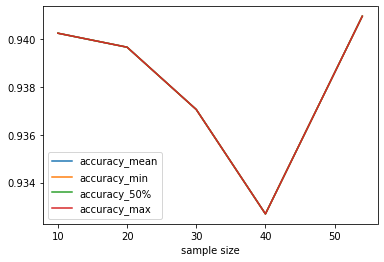

In [39]:
new_df[list(filter(lambda x : x.find('accuracy')>-1, new_df.columns))].plot()

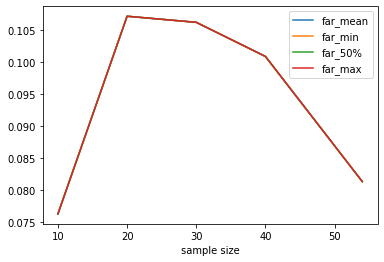

In [40]:
new_df[list(filter(lambda x : x.find('far')>-1, new_df.columns))].plot()

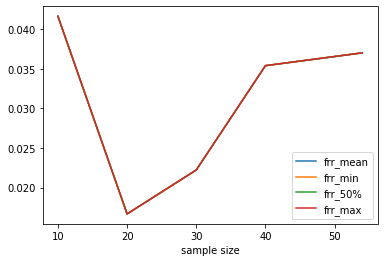

In [41]:
new_df[list(filter(lambda x : x.find('frr')>-1, new_df.columns))].plot()

In [42]:
new_df[list(filter(lambda x : x.find('accuracy')>-1, new_df.columns))]

,accuracy_mean,accuracy_min,accuracy_50%,accuracy_max
sample size,,,,
10,0.940239,0.940239,0.940239,0.940239
20,0.939655,0.939655,0.939655,0.939655
30,0.937053,0.937053,0.937053,0.937053
40,0.932692,0.932692,0.932692,0.932692
54,0.940948,0.940948,0.940948,0.940948


In [43]:
new_df[list(filter(lambda x : x.find('far')>-1, new_df.columns))]

,far_mean,far_min,far_50%,far_max
sample size,,,,
10,0.0763359,0.0763359,0.0763359,0.0763359
20,0.107143,0.107143,0.107143,0.107143
30,0.106195,0.106195,0.106195,0.106195
40,0.100877,0.100877,0.100877,0.100877
54,0.0813772,0.0813772,0.0813772,0.0813772


In [44]:
new_df[list(filter(lambda x : x.find('frr')>-1, new_df.columns))]

,frr_mean,frr_min,frr_50%,frr_max
sample size,,,,
10,0.0416667,0.0416667,0.0416667,0.0416667
20,0.0166667,0.0166667,0.0166667,0.0166667
30,0.0222222,0.0222222,0.0222222,0.0222222
40,0.0354167,0.0354167,0.0354167,0.0354167
54,0.037037,0.037037,0.037037,0.037037
